<a href="https://colab.research.google.com/github/desnug/Audio_alarm_classification/blob/main/spec_Conv2D_1sdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 5.2 MB/s 


Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [ ]:
import numpy as np
import requests
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/MyDrive/data/spectr/Conv2D")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Store the data in a temporary file, and load it back through Numpy.

In [ ]:
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [ ]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [ ]:
input_length

5135

Train the model:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
channels = 1
columns = 65
rows = int(input_length / (columns * channels))
model.add(Reshape((rows, columns, channels), input_shape=(input_length, )))
model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 79, 65, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 79, 65, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 33, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 33, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 17, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 17, 32)        4

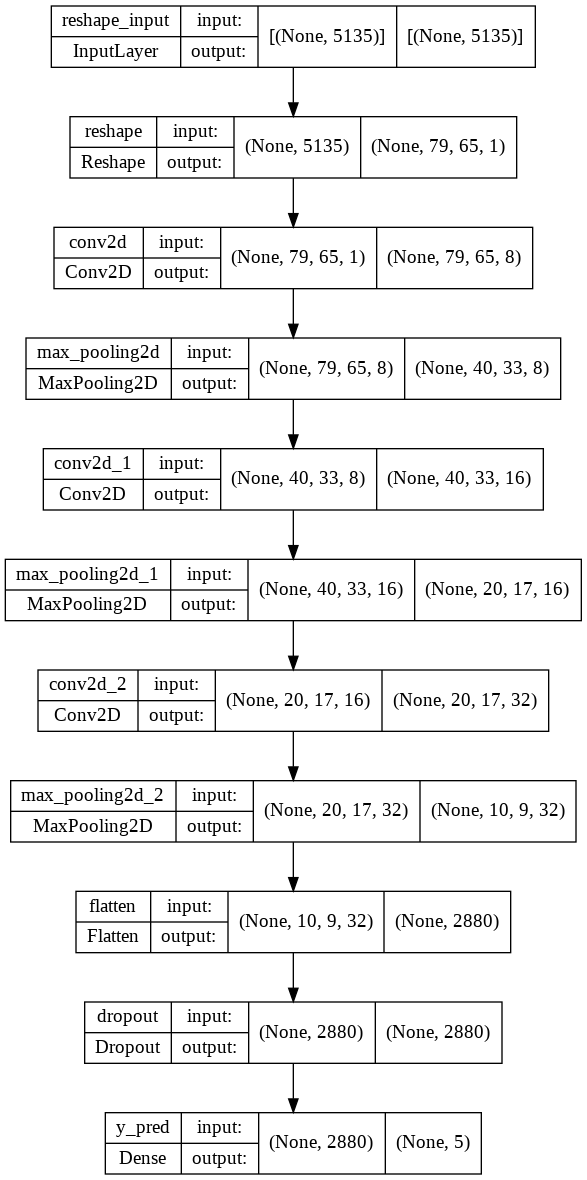

In [ ]:
# visualize model architecture
import visualkeras
from PIL import ImageFont
from tensorflow.keras.utils import plot_model

#plot model deep learning
plot_model(model, to_file="model-architecture.png", show_shapes=True)

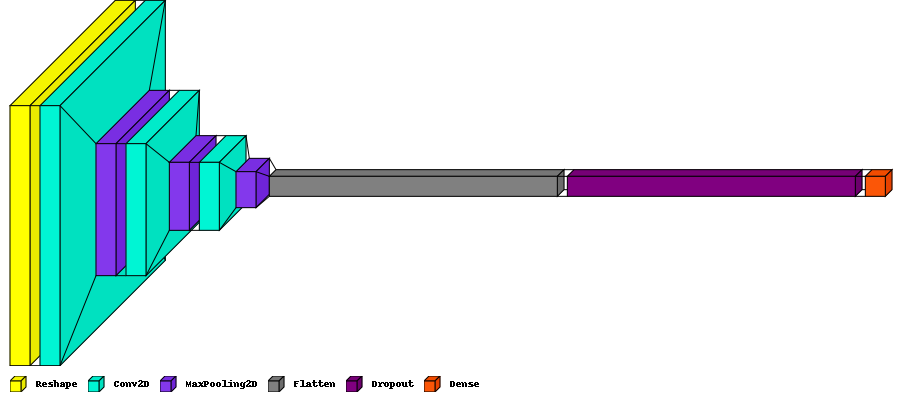

In [ ]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Reshape]['fill'] = 'yellow'
color_map[Conv2D]['fill'] = '#00f5d4'
color_map[Dropout]['fill'] = 'purple'
color_map[MaxPooling2D]['fill'] = '#8338ec'
color_map[Dense]['fill'] = '#fb5607'
color_map[Flatten]['fill'] = 'grey'

visualkeras.layered_view(model, legend=True, color_map=color_map)

In [ ]:
# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False

Epoch 1/30
75/75 - 13s - loss: 0.6970 - accuracy: 0.7550 - val_loss: 0.3027 - val_accuracy: 0.8967 - 13s/epoch - 178ms/step
Epoch 2/30
75/75 - 7s - loss: 0.2258 - accuracy: 0.9146 - val_loss: 0.2383 - val_accuracy: 0.9167 - 7s/epoch - 90ms/step
Epoch 3/30
75/75 - 7s - loss: 0.1439 - accuracy: 0.9500 - val_loss: 0.0980 - val_accuracy: 0.9650 - 7s/epoch - 88ms/step
Epoch 4/30
75/75 - 7s - loss: 0.0833 - accuracy: 0.9725 - val_loss: 0.0992 - val_accuracy: 0.9617 - 7s/epoch - 89ms/step
Epoch 5/30
75/75 - 7s - loss: 0.0817 - accuracy: 0.9754 - val_loss: 0.0646 - val_accuracy: 0.9783 - 7s/epoch - 88ms/step
Epoch 6/30
75/75 - 7s - loss: 0.0715 - accuracy: 0.9771 - val_loss: 0.0749 - val_accuracy: 0.9717 - 7s/epoch - 88ms/step
Epoch 7/30
75/75 - 7s - loss: 0.0477 - accuracy: 0.9837 - val_loss: 0.0424 - val_accuracy: 0.9867 - 7s/epoch - 88ms/step
Epoch 8/30
75/75 - 7s - loss: 0.0443 - accuracy: 0.9854 - val_loss: 0.0559 - val_accuracy: 0.9800 - 7s/epoch - 88ms/step
Epoch 9/30
75/75 - 7s - loss:

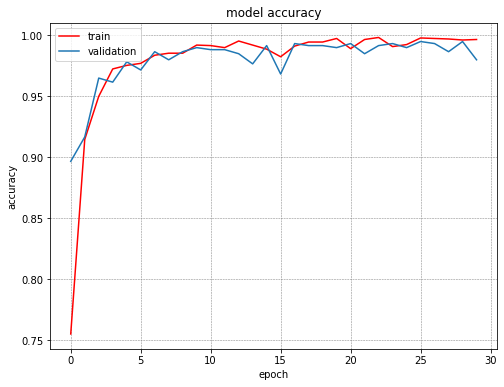

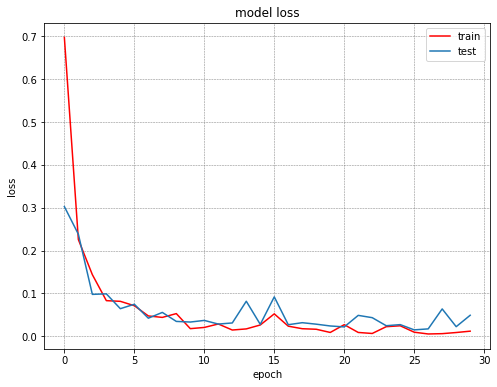

In [ ]:
# Plot Accuracy and Loss
import matplotlib.pyplot as plt
#plot accuracy and loss model
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
# final Accuracy and Loss
final_loss, final_acc = model.evaluate(validation_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.049257, final accuracy: 0.980000


In [ ]:
# Save the model to disk
model.save('saved_model')

In [ ]:
# convert Model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_audio.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Save the model to H5
model.save('saved_model.h5')

In [ ]:
import numpy as np
# Extract samples and labels from validation set (which is batched)
X_val = np.concatenate([x for x, _ in validation_dataset], axis=0)
y_val = np.concatenate([y for _, y in validation_dataset], axis=0)

# Run inference on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)

# Convert one-hot encoding to label encoding for ground-truth labels
y_true = np.argmax(y_val, axis=1)

def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

# print("Testing Accuracy: " + str(acc(y_true, y_pred)))

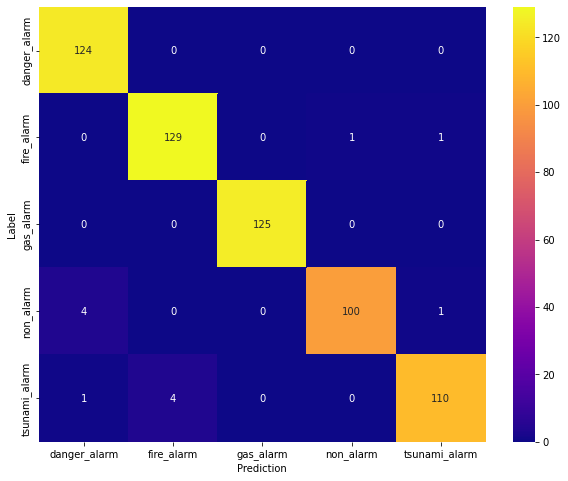

In [ ]:
import seaborn as sns

# Labels from project
labels = ["danger_alarm", "fire_alarm", "gas_alarm", "non_alarm", "tsunami_alarm"]

# Show confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g', cmap="plasma")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.98023715, 0.97727273, 1.        , 0.97087379, 0.969163  ])